In [25]:
%load_ext autoreload
%autoreload 2

In [113]:
import sys

if './shap' not in sys.path:
    sys.path = ['./shap'] + sys.path
    import shap

import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
from graphviz import Digraph, Source
from pygraphviz import AGraph
import numpy as np
import matplotlib.image as mpimg
from IPython.display import Image
import matplotlib.pyplot as plt
from flow import main, Node, CreditFlow, Graph, get_source_nodes, topo_sort, flatten_graph, eval_graph
from flow import translator, boundary_graph, single_source_graph, viz_graph, save_graph, hcluster_graph
import copy
import seaborn as sns
import scipy as sp
import scipy.cluster
from collections import defaultdict
import matplotlib.pyplot as pl
from itertools import product

In [3]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True) # human readable feature values

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

print(X.shape)
X_display.head()

(32561, 12)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [4]:
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 3,
    'objective':'binary:logistic',
    "subsample": 0.5
}
model = xgboost.train(params, xgb_train, 1000, evals = [(xgb_test, "test")], verbose_eval=1000)

# workaround from https://github.com/slundberg/shap/issues/1215
mybooster = model

model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

[0]	test-error:0.15461
[999]	test-error:0.15001


In [114]:
def build_graph(names, model, X, x, display_translator={}):
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph
    nodes = [Node(name) for name in names]
    nodes.append(Node('predicted income >50k', 
                      lambda *args: model.predict(xgboost.DMatrix(pd.DataFrame.from_dict(dict((name, args[i]) for i, name in enumerate(names))))),
                      nodes, is_target_node=True))
    
    def idx_f(idx, f):
        def f_():
            return f(idx)
        return f_
    
    graph = Graph(nodes,
                  dict((name, idx_f(i, lambda i: np.array(X)[np.random.choice(len(X), len(x))][:, i])) 
                       for i, name in enumerate(names)),
                  dict((name, idx_f(i, lambda i: np.array(x)[:, i])) 
                       for i, name in enumerate(names)),
                  display_translator)

    return graph

nsamples = 1000
names = list(X.columns)
graph = build_graph(names, model, X, X[:nsamples], translator(names, X, X_display))
verbose = False
cf = CreditFlow(graph, verbose=verbose, nruns=100, visualize=verbose)
cf.run()

sampling: 100%|██████████| 100/100 [00:10<00:00,  9.73it/s]


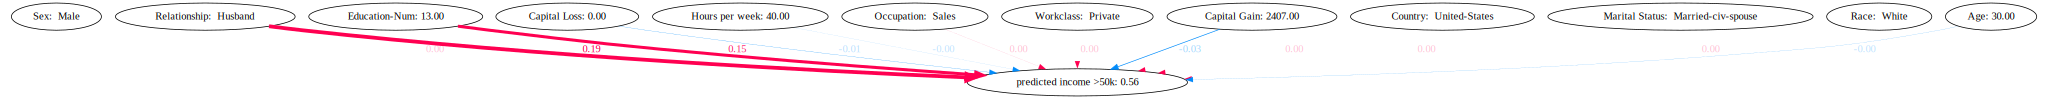

In [115]:
sample_ind = 60
G = cf.credit2dot(format_str='{:.2f}', idx=sample_ind)
viz_graph(G)

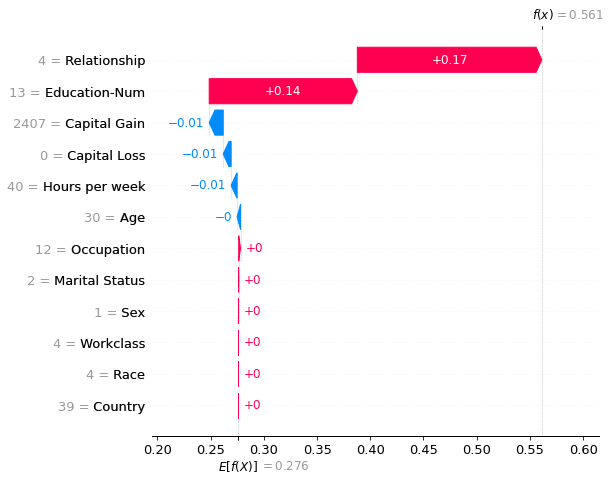

In [71]:
explainer = shap.SamplingExplainer(lambda x: model.predict(xgboost.DMatrix(x), validate_features=False), X, nsamples=1000) # nsamples=1000 * number of varying parameters
shap_values = explainer.shap_values(X.iloc[sample_ind:sample_ind+1])

shap.waterfall_plot(explainer.expected_value, shap_values[0], X.iloc[sample_ind], max_display=20)

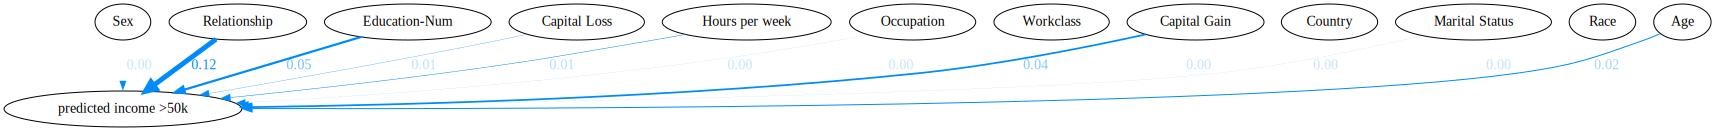

In [119]:
G = cf.credit2dot(format_str='{:.2f}', idx=-1)
viz_graph(G)

In [109]:
bg = shap.utils.sample(X, 100)
explainer = shap.Explainer(lambda x: model.predict(xgboost.DMatrix(x), validate_features=False), bg)
shap_values = explainer(X[:500])

Permutation explainer: 501it [01:05,  7.65it/s]                         


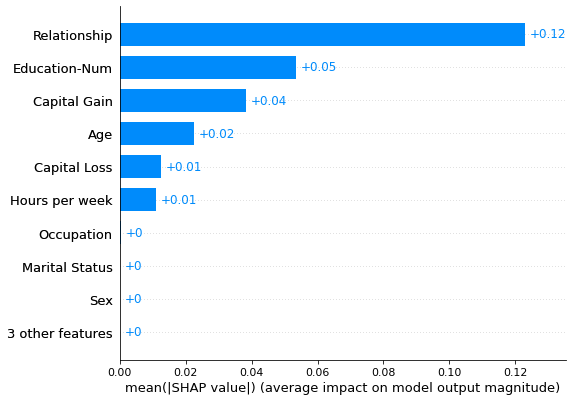

In [112]:
shap.plots.bar(shap_values)

In [6]:
print(X_display.iloc[sample_ind])
print('target:', model.predict(xgboost.DMatrix(X.iloc[sample_ind:sample_ind+1], label=y[sample_ind:sample_ind+1])))
print('target:', model.predict(xgboost.DMatrix(X.iloc[sample_ind:sample_ind+1])))

Age                                30
Workclass                     Private
Education-Num                      13
Marital Status     Married-civ-spouse
Occupation                      Sales
Relationship                  Husband
Race                            White
Sex                              Male
Capital Gain                     2407
Capital Loss                        0
Hours per week                     40
Country                 United-States
Name: 60, dtype: object
target: [0.56124014]
target: [0.56124014]


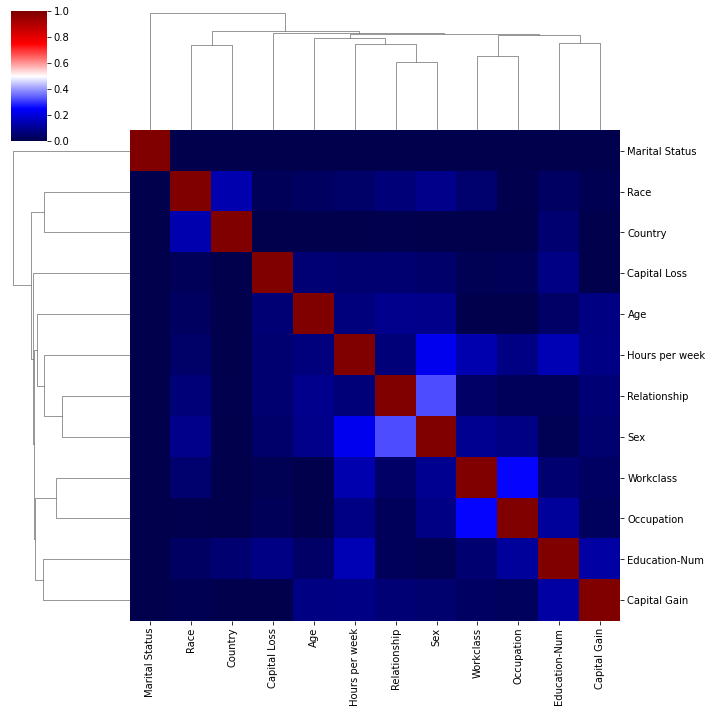

In [13]:
sns.clustermap(X.corr(), cmap='seismic', vmax=1, vmin=0)

In [18]:
X_display[['Relationship', 'Marital Status']]

,Relationship,Marital Status
0,Not-in-family,Never-married
1,Husband,Married-civ-spouse
2,Not-in-family,Divorced
3,Husband,Married-civ-spouse
4,Wife,Married-civ-spouse
...,...,...
32556,Wife,Married-civ-spouse
32557,Husband,Married-civ-spouse
32558,Unmarried,Widowed
32559,Own-child,Never-married


In [22]:
print(X.columns)
graph.nodes

Index(['Age', 'Workclass', 'Education-Num', 'Marital Status', 'Occupation',
       'Relationship', 'Race', 'Sex', 'Capital Gain', 'Capital Loss',
       'Hours per week', 'Country'],
      dtype='object')


[Relationship,
 Occupation,
 Capital Gain,
 Sex,
 Workclass,
 Marital Status,
 Country,
 Race,
 Capital Loss,
 predicted income >50k,
 Education-Num,
 Hours per week,
 Age]

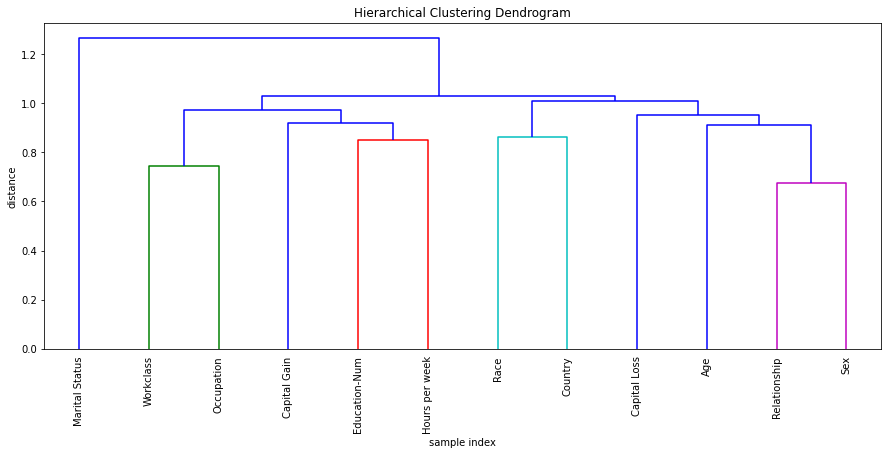

In [20]:
D = sp.spatial.distance.pdist(X.fillna(X.mean()).T, metric="correlation")
cluster_matrix = sp.cluster.hierarchy.complete(D)

# plot the clustering
pl.figure(figsize=(15, 6))
pl.title('Hierarchical Clustering Dendrogram')
pl.xlabel('sample index')
pl.ylabel('distance')
sp.cluster.hierarchy.dendrogram(
    cluster_matrix,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    labels=X.columns
)
pl.show()

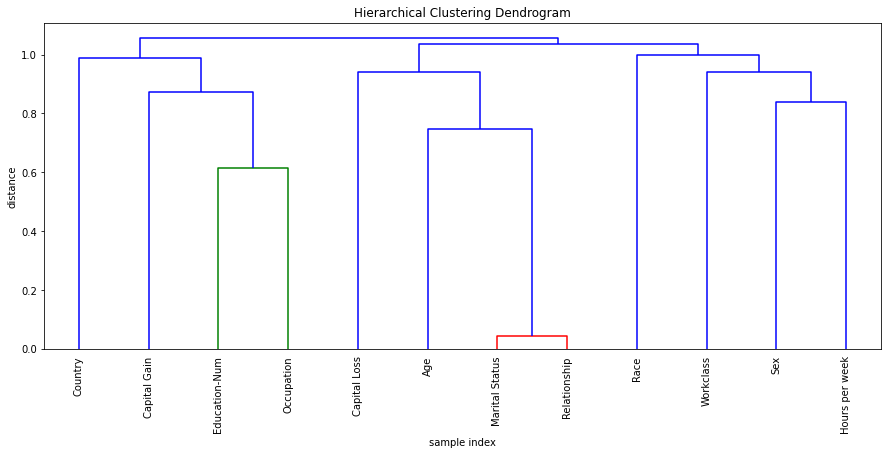

In [10]:
cluster_matrix = shap.utils.hclust(X, y)

# plot the clustering
pl.figure(figsize=(15, 6))
pl.title('Hierarchical Clustering Dendrogram')
pl.xlabel('sample index')
pl.ylabel('distance')
sp.cluster.hierarchy.dendrogram(
    cluster_matrix,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    labels=X.columns
)
pl.show()

sampling: 100%|██████████| 200/200 [00:27<00:00,  7.18it/s]


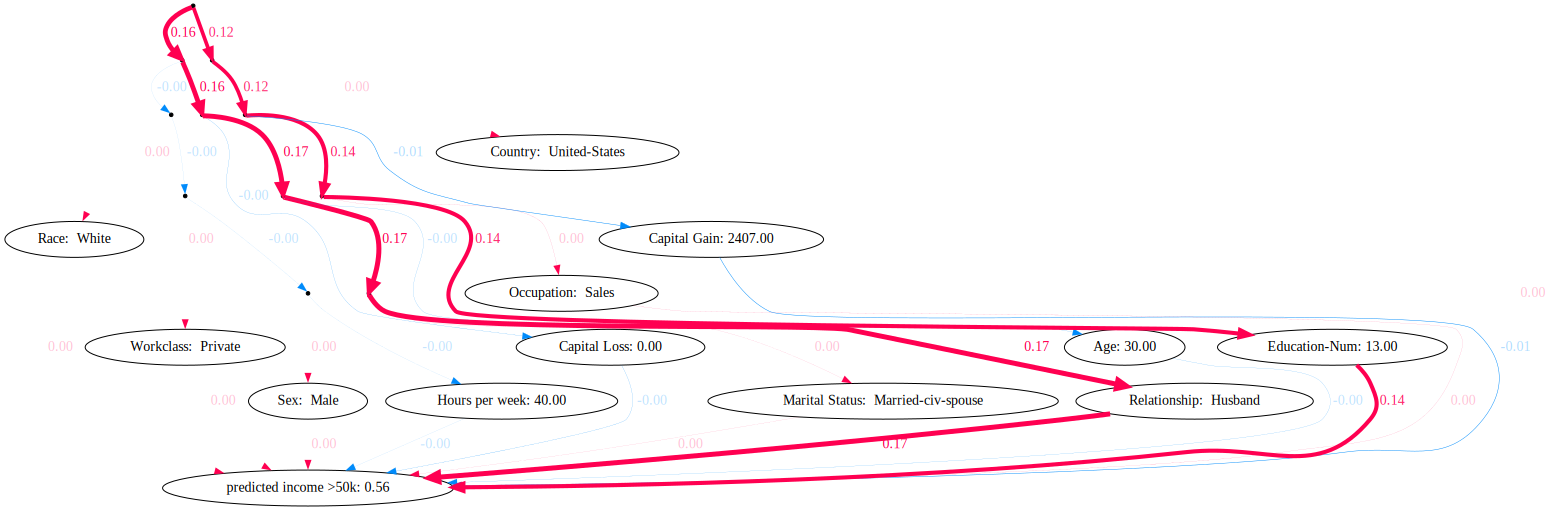

In [108]:
nsamples = 1000
names = list(X.columns)
graph = build_graph(names, model, X, X[:nsamples], translator(names, X, X_display))
hgraph = hcluster_graph(graph, list(X.columns), cluster_matrix)
verbose = False #True
cf = CreditFlow(hgraph, verbose=verbose, nruns=200, visualize=verbose)
cf.run()

sample_ind = 60
G = cf.credit2dot(format_str='{:.2f}', idx=sample_ind)
viz_graph(G)
# save_graph(G, 'graph.png')

# Incorporate a causal understanding 

Following the ASV paper, we group features that are determined at birth from the rest of the features

Therefore, we have the following causal graph:

In [39]:
A = ['Age', 'Sex', 'Country', 'Race']
D = list(set(X.columns) - set(A))
A, D

(['Age', 'Sex', 'Country', 'Race'],
 ['Workclass',
  'Relationship',
  'Hours per week',
  'Occupation',
  'Capital Gain',
  'Marital Status',
  'Education-Num',
  'Capital Loss'])

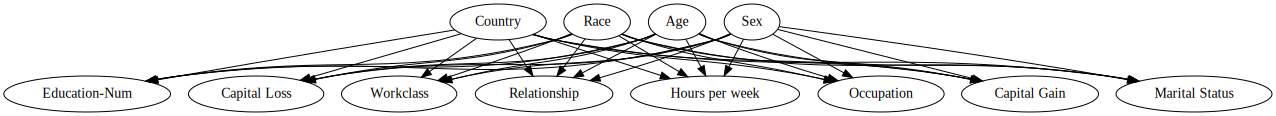

In [41]:
dot = Digraph()
idx = 0
idx_A = []
idx_D = []
for name in A:
    dot.node(f'{idx}', name)
    idx_A.append(idx)
    idx += 1

for name in D:
    dot.node(f'{idx}', name)
    idx_D.append(idx)
    idx += 1

for a, d in product(idx_A, idx_D):
    dot.edge(str(a), str(d))
dot

While causal ordering requires that features should occur at specific order, the noise terms of the nodes have no reason to follow that. Theirfore a complete causal graph looks like this.

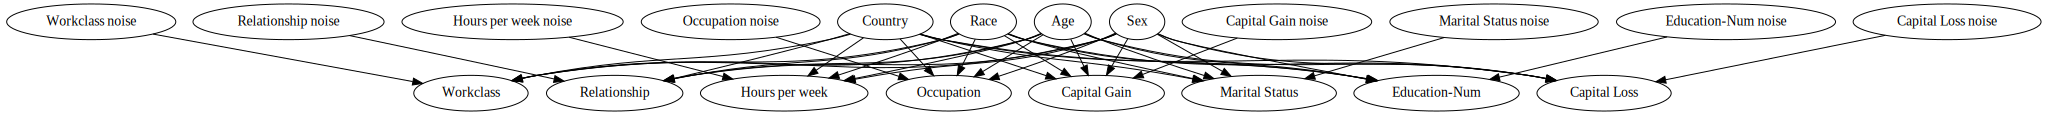

In [43]:
dot = Digraph()
idx = 0
idx_A = []
idx_D = []
idx_D_noise = []
for name in A:
    dot.node(f'{idx}', name)
    idx_A.append(idx)
    idx += 1

for name in D:
    dot.node(f'{idx}', name)
    idx_D.append(idx)
    idx += 1

for name in D:
    dot.node(f'{idx}', name + ' noise')
    idx_D_noise.append(idx)
    idx += 1

for a, d in product(idx_A, idx_D):
    dot.edge(str(a), str(d))
    
for d_n, d in zip(idx_D_noise, idx_D):
    dot.edge(str(d_n), str(d))
    
dot

Now we know the importance of Sex and also what path it took. With ASV, we don't know what is the important path. With shap, we don't know the dependency of features.